In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
datapath = '/Users/sidsatya/dev/ailabor/task_classification/data/intermediate_results/classified_tasks_16_dim_intermediate.csv'
data = pd.read_csv(datapath)

In [25]:
def read_gpt_label(label):
    # label is formatted as a JSON string with 10 key-value pairs
    label = label.replace("'", '"')  # Replace single quotes with double quotes
    label = label.replace('nan', 'null')  # Replace 'nan' with 'null' for JSON compatibility
    try:
        label_dict = eval(label)  # Use eval to convert the string to a dictionary
        return label_dict
    except Exception as e:
        print(f"Error parsing label: {e}")
        return {}

data['read_label'] = data['gpt_label'].apply(read_gpt_label)
data['interpersonal'] = data['read_label'].apply(lambda x: 1 if x.get('Interpersonal', 'No') == 'Yes' else 0)
data['routine'] = data['read_label'].apply(lambda x: 1 if x.get('Routine', 'No') == 'Yes' else 0)
data['manual'] = data['read_label'].apply(lambda x: 1 if x.get('Manual', 'No') == 'Yes' else 0)
data['high_codifiable'] = data['read_label'].apply(lambda x: 1 if x.get('High Cod.', 'No') == 'Yes' else 0)

Error parsing label: name 'gpt_label' is not defined
Error parsing label: name 'gpt_label' is not defined
Error parsing label: name 'gpt_label' is not defined
Error parsing label: name 'gpt_label' is not defined
Error parsing label: name 'gpt_label' is not defined
Error parsing label: name 'gpt_label' is not defined
Error parsing label: name 'gpt_label' is not defined
Error parsing label: name 'gpt_label' is not defined


In [26]:
# Group by Task and compute mode and mean for each category
grouped_data = data.groupby('Task').agg({
    'interpersonal': ['mean', lambda x: x.mode()[0] if not x.mode().empty else 0],
    'routine': ['mean', lambda x: x.mode()[0] if not x.mode().empty else 0],
    'manual': ['mean', lambda x: x.mode()[0] if not x.mode().empty else 0],
    'high_codifiable': ['mean', lambda x: x.mode()[0] if not x.mode().empty else 0]
}).reset_index()

# collapse the multi-level columns into dimension_mean and dimension_mode
grouped_data.columns = ['Task', 'interpersonal_mean', 'interpersonal_mode',
                        'routine_mean', 'routine_mode',
                        'manual_mean', 'manual_mode',
                        'high_codifiable_mean', 'high_codifiable_mode']

print(grouped_data.shape)
grouped_data.head(2)

(8184, 9)


,Task,interpersonal_mean,interpersonal_mode,routine_mean,routine_mode,manual_mean,manual_mode,high_codifiable_mean,high_codifiable_mode
0,Accept and check containers of mail or parcels...,1.0,1,1.0,1,1.0,1,0.5,0
1,Accept commissions to create music for special...,1.0,1,0.0,0,0.0,0,0.0,0


In [27]:
# Merge with the overall task dataset 
all_datapath = '/Users/sidsatya/dev/ailabor/onet_transformations/intermediate_data/task_data_merged_attributes.csv'
all_data = pd.read_csv(all_datapath)

# Merge all_data with grouped data on 'Task'
merged_data = pd.merge(all_data, grouped_data, on='Task', how='left')
print(merged_data.shape)
print(merged_data[merged_data['interpersonal_mean'].notna()].shape)
merged_data.head(2)

(420543, 32)
(123750, 32)


,O*NET-SOC Code,O*NET 2010 SOC Code,O*NET 2018 SOC Code,ONET_release_year,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,...,last_seen,active,interpersonal_mean,interpersonal_mode,routine_mean,routine_mode,manual_mean,manual_mode,high_codifiable_mean,high_codifiable_mode
0,11-1011.01,11-1011.00,11-1011,2003,NaN,Directs organization charged with administerin...,NaN,NaN,3/2002,Legacy Analyst,...,2005,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11-1011.01,11-1011.00,11-1011,2003,NaN,"Administers, interprets, and explains policies...",NaN,NaN,3/2002,Legacy Analyst,...,2005,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Routine-Cognitive: any task with routine = 1 and manual = 0
# Routine-Manual: any task with routine = 1 and manual = 1
# Non-Routine Manual: any task with routine = 0 and manual = 1
# Non-Routine Interpersonal: any task with routine = 0 and interpersonal = 1
# Non Routine Analytical: any task with routine = 0 and manual = 0 and interpersonal = 0
# Highly Codifiable: any task with high_codifiable = 1
# Non Highly Codifiable: any task with high_codifiable = 0
# Label each task based on the above criteria and using the 'mode' labels and assign them to new columns
def label_task_alm(row):
    if row['routine_mode'] == 1 and row['manual_mode'] == 0:
        return 'Routine-Cognitive'
    elif row['routine_mode'] == 1 and row['manual_mode'] == 1:
        return 'Routine-Manual'
    elif row['routine_mode'] == 0 and row['manual_mode'] == 1:
        return 'Non-Routine Manual'
    elif row['routine_mode'] == 0 and row['interpersonal_mode'] == 1:
        return 'Non-Routine Interpersonal'
    elif row['routine_mode'] == 0 and row['manual_mode'] == 0 and row['interpersonal_mode'] == 0:
        return 'Non Routine Analytical'
    else: 
        return "Unclassified"
    
def label_task_codifiable(row):
    if row['high_codifiable_mode'] == 1 and row['manual_mode'] == 0:
        return 'High Codifiable-Cognitive'
    elif row['high_codifiable_mode'] == 1 and row['manual_mode'] == 1:
        return 'High Codifiable-Manual'
    elif row['high_codifiable_mode'] == 0 and row['manual_mode'] == 0:
        return 'Low Codifiable-Cognitive'
    elif row['high_codifiable_mode'] == 0 and row['interpersonal_mode'] == 1:
        return 'Low Codifiable-Manual'
    else: 
        return "Unclassified"
    
# Drop any row with NaN in the mode columns
merged_data['task_label_alm'] = merged_data.apply(label_task_alm, axis=1)
merged_data['task_label_codifiable'] = merged_data.apply(label_task_codifiable, axis=1)

In [29]:
merged_data.columns

Index(['O*NET-SOC Code', 'O*NET 2010 SOC Code', 'O*NET 2018 SOC Code',
       'ONET_release_year', 'Task ID', 'Task', 'Task Type',
       'Incumbents Responding', 'Date', 'Domain Source', 'Count', 'task_clean',
       'canon_id', 'Mean Importance', 'Mean Frequency',
       'normalized_importance', 'normalized_importance_core',
       'normalized_frequency', 'normalized_frequency_core', 'task_intensity',
       'task_intensity_core', 'first_seen', 'last_seen', 'active',
       'interpersonal_mean', 'interpersonal_mode', 'routine_mean',
       'routine_mode', 'manual_mean', 'manual_mode', 'high_codifiable_mean',
       'high_codifiable_mode', 'task_label_alm', 'task_label_codifiable'],
      dtype='object')

In [30]:
obs_with_mode_and_intensity = merged_data[merged_data['task_intensity'].notna()]

# Group by O*NET SOC Code and ONET_release_year, aggregating the task labels and task intensity
# Sum task_intensity for each task_label within each group
alm_task_intensity_by_label = obs_with_mode_and_intensity.pivot_table(
    index=['O*NET-SOC Code', 'O*NET 2010 SOC Code', 'O*NET 2018 SOC Code', 'ONET_release_year'],
    columns='task_label_alm',
    values='task_intensity',
    aggfunc='sum',
    fill_value=0
)
cod_task_intensity_by_label = obs_with_mode_and_intensity.pivot_table(
    index=['O*NET-SOC Code', 'O*NET 2010 SOC Code', 'O*NET 2018 SOC Code', 'ONET_release_year'],
    columns='task_label_codifiable',
    values='task_intensity',
    aggfunc='sum',
    fill_value=0
)

# Reset index to flatten the DataFrame
alm_task_intensity_by_label = alm_task_intensity_by_label.reset_index()
alm_task_intensity_by_label.columns = ['O*NET-SOC Code', 'O*NET 2010 SOC Code', 'O*NET 2018 SOC Code', 'ONET_release_year'] + list(alm_task_intensity_by_label.columns[4:])

cod_task_intensity_by_label = cod_task_intensity_by_label.reset_index()
cod_task_intensity_by_label.columns = ['O*NET-SOC Code', 'O*NET 2010 SOC Code', 'O*NET 2018 SOC Code', 'ONET_release_year'] + list(cod_task_intensity_by_label.columns[4:])

alm_task_intensity_by_label

,O*NET-SOC Code,O*NET 2010 SOC Code,O*NET 2018 SOC Code,ONET_release_year,Non Routine Analytical,Non-Routine Interpersonal,Non-Routine Manual,Routine-Cognitive,Routine-Manual,Unclassified
0,11-1011.00,11-1011.00,11-1011,2006,0.0,0.0,0.0,0.0,0.0,1.0
1,11-1011.00,11-1011.00,11-1011,2007,0.0,0.0,0.0,0.0,0.0,1.0
2,11-1011.00,11-1011.00,11-1011,2008,0.0,0.0,0.0,0.0,0.0,1.0
3,11-1011.00,11-1011.00,11-1011,2009,0.0,0.0,0.0,0.0,0.0,1.0
4,11-1011.00,11-1011.00,11-1011,2010,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15025,53-7121.00,53-7121.00,53-7121,2021,0.0,0.0,0.0,0.0,0.0,1.0
15026,53-7121.00,53-7121.00,53-7121,2022,0.0,0.0,0.0,0.0,0.0,1.0
15027,53-7121.00,53-7121.00,53-7121,2023,0.0,0.0,0.0,0.0,0.0,1.0
15028,53-7121.00,53-7121.00,53-7121,2024,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
# Merge with BLS data
bls_datapath = '/Users/sidsatya/dev/ailabor/bls_transformations/output_data/total_emp_by_year_soc_2018.csv'
bls_emp_data = pd.read_csv(bls_datapath)

# Merge BLS data with the aggregated task intensity data
merged_bls_data_alm = pd.merge(alm_task_intensity_by_label, bls_emp_data, left_on=['O*NET 2018 SOC Code', 'ONET_release_year'], right_on = ['soc_2018', 'year'], how='inner')
merged_bls_data_cod = pd.merge(cod_task_intensity_by_label, bls_emp_data, left_on=['O*NET 2018 SOC Code', 'ONET_release_year'], right_on = ['soc_2018', 'year'], how='inner')

# Drop rows with Unclassified tasks
merged_bls_data_alm = merged_bls_data_alm[merged_bls_data_alm['Unclassified'] == 0]
merged_bls_data_cod = merged_bls_data_cod[merged_bls_data_cod['Unclassified'] == 0]

merged_bls_data_alm

,O*NET-SOC Code,O*NET 2010 SOC Code,O*NET 2018 SOC Code,ONET_release_year,Non Routine Analytical,Non-Routine Interpersonal,Non-Routine Manual,Routine-Cognitive,Routine-Manual,Unclassified,year,soc_2018,occ_code,soc_2010,occ_title,tot_emp_clean,pct_of_total_emp
118,11-3021.00,11-3021.00,11-3021,2004,0.423934,0.426490,0.000000,0.111654,0.037923,0.0,2004,11-3021,11-3021,11-3021,Computer and information systems managers,267390.0,0.002087
119,11-3021.00,11-3021.00,11-3021,2005,0.423934,0.426490,0.000000,0.111654,0.037923,0.0,2005,11-3021,11-3021,11-3021,Computer and information systems managers,259330.0,0.001990
120,11-3021.00,11-3021.00,11-3021,2006,0.423934,0.426490,0.000000,0.111654,0.037923,0.0,2006,11-3021,11-3021,11-3021,Computer and information systems managers,251210.0,0.001894
121,11-3021.00,11-3021.00,11-3021,2007,0.423934,0.426490,0.000000,0.111654,0.037923,0.0,2007,11-3021,11-3021,11-3021,Computer and information systems managers,264990.0,0.001972
122,11-3021.00,11-3021.00,11-3021,2008,0.404523,0.445725,0.000000,0.103310,0.046442,0.0,2008,11-3021,11-3021,11-3021,Computer and information systems managers,276820.0,0.002048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13145,53-3011.00,53-3011.00,53-3011,2020,0.000000,0.097449,0.190132,0.047131,0.665288,0.0,2020,53-3011,53-3011,53-3011,"Ambulance Drivers and Attendants, Except Emerg...",14120.0,0.000102
13146,53-3011.00,53-3011.00,53-3011,2021,0.000000,0.097449,0.190132,0.047131,0.665288,0.0,2021,53-3011,53-3011,53-3011,"Ambulance Drivers and Attendants, Except Emerg...",11710.0,0.000083
13147,53-3011.00,53-3011.00,53-3011,2022,0.000000,0.097449,0.190132,0.047131,0.665288,0.0,2022,53-3011,53-3011,53-3011,"Ambulance Drivers and Attendants, Except Emerg...",9910.0,0.000067
13148,53-3011.00,53-3011.00,53-3011,2023,0.000000,0.097449,0.190132,0.047131,0.665288,0.0,2023,53-3011,53-3011,53-3011,"Ambulance Drivers and Attendants, Except Emerg...",11520.0,0.000076


### ALM Graph

In [32]:
merged_bls_data_alm['non_routine_analytical_weighted'] = merged_bls_data_alm['Non Routine Analytical'] * merged_bls_data_alm['pct_of_total_emp']
merged_bls_data_alm['non_routine_interpersonal_weighted'] = merged_bls_data_alm['Non-Routine Interpersonal'] * merged_bls_data_alm['pct_of_total_emp']
merged_bls_data_alm['non_routine_manual_weighted'] = merged_bls_data_alm['Non-Routine Manual'] * merged_bls_data_alm['pct_of_total_emp']
merged_bls_data_alm['routine_cognitive_weighted'] = merged_bls_data_alm['Routine-Cognitive'] * merged_bls_data_alm['pct_of_total_emp']
merged_bls_data_alm['routine_manual_weighted'] = merged_bls_data_alm['Routine-Manual'] * merged_bls_data_alm['pct_of_total_emp']

# Sum the total weighted task intensities for each dimension in each year. Normalize wrt to sum across all dimension in each year
total_weighted_intensity = merged_bls_data_alm.groupby('ONET_release_year').agg({
    'non_routine_analytical_weighted': 'sum',
    'non_routine_interpersonal_weighted': 'sum',
    'non_routine_manual_weighted': 'sum',
    'routine_cognitive_weighted': 'sum',
    'routine_manual_weighted': 'sum'
}).reset_index()
total_weighted_intensity['total_weighted_intensity'] = total_weighted_intensity[['non_routine_analytical_weighted', 
                                                                                     'non_routine_interpersonal_weighted', 
                                                                                     'non_routine_manual_weighted', 
                                                                                     'routine_cognitive_weighted', 
                                                                                     'routine_manual_weighted']].sum(axis=1)
total_weighted_intensity = total_weighted_intensity.set_index('ONET_release_year')
total_weighted_intensity = total_weighted_intensity.div(total_weighted_intensity['total_weighted_intensity'], axis=0)  

total_weighted_intensity

,non_routine_analytical_weighted,non_routine_interpersonal_weighted,non_routine_manual_weighted,routine_cognitive_weighted,routine_manual_weighted,total_weighted_intensity
ONET_release_year,,,,,,
2003,0.058816,0.158527,0.044887,0.270788,0.466982,1.0
2004,0.129419,0.193077,0.027229,0.348772,0.301504,1.0
2005,0.132232,0.203556,0.033951,0.330394,0.299866,1.0
2006,0.100935,0.200591,0.050409,0.306434,0.341631,1.0
2007,0.102073,0.199338,0.050651,0.304969,0.342969,1.0
2008,0.088377,0.239225,0.047191,0.281820,0.343386,1.0
2009,0.094568,0.247024,0.051421,0.266759,0.340228,1.0
2010,0.103460,0.266554,0.081742,0.171711,0.376532,1.0
2011,0.102444,0.266236,0.073492,0.173918,0.383910,1.0


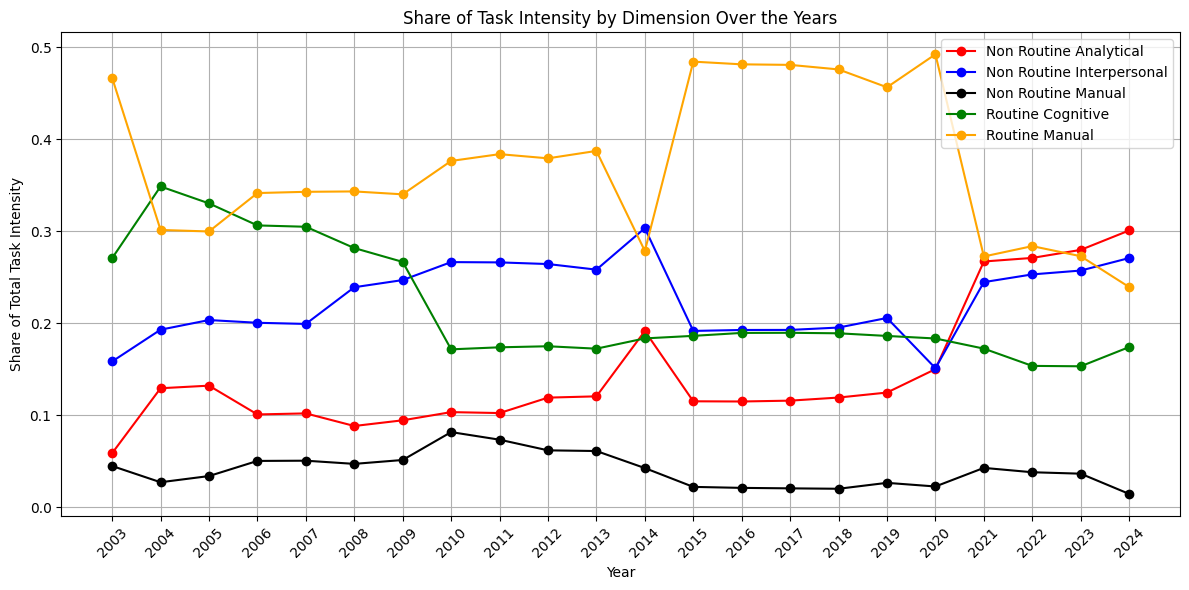

In [33]:
# Plot the the share corresponding to each dimension over the years, line plot
plt.figure(figsize=(12, 6))
plt.plot(total_weighted_intensity.index, total_weighted_intensity['non_routine_analytical_weighted'], label='Non Routine Analytical', marker='o', color='red')
plt.plot(total_weighted_intensity.index, total_weighted_intensity['non_routine_interpersonal_weighted'], label='Non Routine Interpersonal', marker='o', color='blue')
plt.plot(total_weighted_intensity.index, total_weighted_intensity['non_routine_manual_weighted'], label='Non Routine Manual', marker='o', color='black')
plt.plot(total_weighted_intensity.index, total_weighted_intensity['routine_cognitive_weighted'], label='Routine Cognitive', marker='o', color='green')
plt.plot(total_weighted_intensity.index, total_weighted_intensity['routine_manual_weighted'], label='Routine Manual', marker='o', color='orange')
plt.title('Share of Task Intensity by Dimension Over the Years')
plt.xlabel('Year')
plt.ylabel('Share of Total Task Intensity')
plt.xticks(total_weighted_intensity.index, rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Codifiable Graph

In [34]:
merged_bls_data_cod['high_cod_cog'] = merged_bls_data_cod['High Codifiable-Cognitive'] * merged_bls_data_cod['pct_of_total_emp']
merged_bls_data_cod['non_high_cod_cog'] = merged_bls_data_cod['Low Codifiable Cognitive'] * merged_bls_data_cod['pct_of_total_emp']
merged_bls_data_cod['high_cod_man'] = merged_bls_data_cod['High Codifiable-Manual'] * merged_bls_data_cod['pct_of_total_emp']
merged_bls_data_cod['non_high_cod_man'] = merged_bls_data_cod['Low Codifiable Manual'] * merged_bls_data_cod['pct_of_total_emp']

# Sum the total weighted task intensities for each dimension in each year. Normalize wrt to sum across all dimension in each year
total_weighted_intensity = merged_bls_data_cod.groupby('ONET_release_year').agg({
    'high_cod_cog': 'sum',
    'non_high_cod_cog': 'sum',
    'high_cod_man': 'sum',
    'non_high_cod_man': 'sum'
}).reset_index()
total_weighted_intensity['total_weighted_intensity'] = total_weighted_intensity[['high_cod_cog', 
                                                                                     'non_high_cod_cog',
                                                                                     'high_cod_man',
                                                                                     'non_high_cod_man']].sum(axis=1)
total_weighted_intensity = total_weighted_intensity.set_index('ONET_release_year')
total_weighted_intensity = total_weighted_intensity.div(total_weighted_intensity['total_weighted_intensity'], axis=0)  

total_weighted_intensity

KeyError: 'Low Codifiable Cognitive'

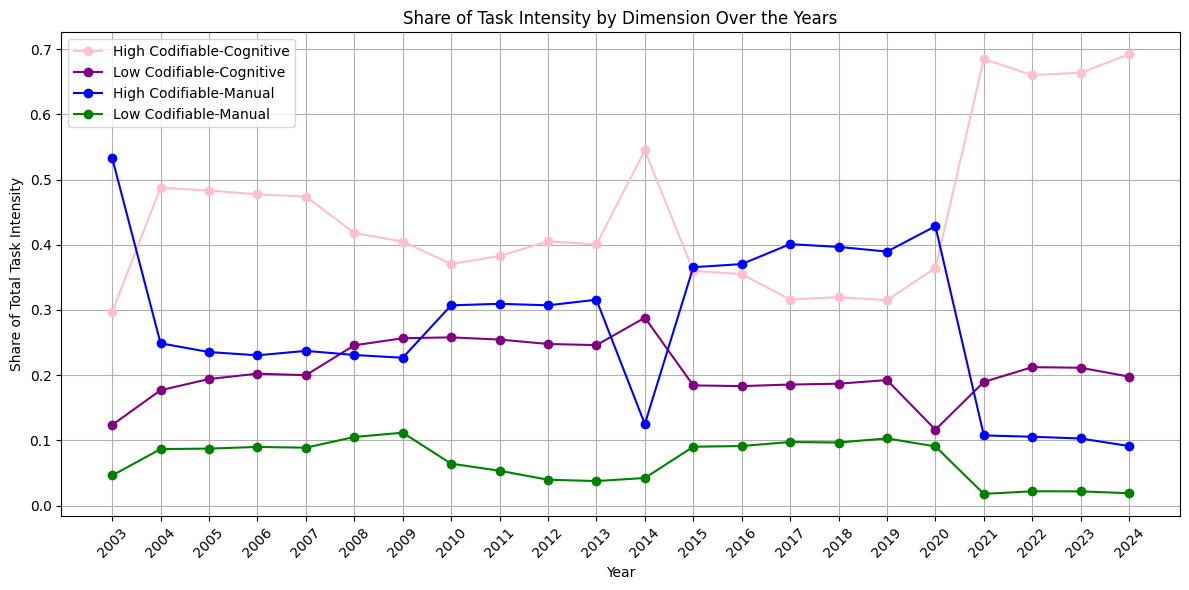

In [ ]:
# Plot the the share corresponding to each dimension over the years, line plot
plt.figure(figsize=(12, 6))
plt.plot(total_weighted_intensity.index, total_weighted_intensity['high_cod_cog'], label='High Codifiable-Cognitive', marker='o', color='pink')
plt.plot(total_weighted_intensity.index, total_weighted_intensity['non_high_cod_cog'], label='Low Codifiable-Cognitive', marker='o', color='purple')
plt.plot(total_weighted_intensity.index, total_weighted_intensity['high_cod_man'], label='High Codifiable-Manual', marker='o', color='blue')
plt.plot(total_weighted_intensity.index, total_weighted_intensity['non_high_cod_man'], label='Low Codifiable-Manual', marker='o', color='green')
plt.title('Share of Task Intensity by Dimension Over the Years')
plt.xlabel('Year')
plt.ylabel('Share of Total Task Intensity')
plt.xticks(total_weighted_intensity.index, rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()